In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [35]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
# Calculate the date 1 year ago from the last data point in the database

# Find out query date
query_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 

# Find our last date in a data set as a string
end_date_string = query_date[0]

# Convert string to datetime
end_date_datetime = dt.datetime.strptime(end_date_string,'%Y-%m-%d').date()

# Find out our start date time
start_date_datetime = end_date_datetime - dt.timedelta(days=365)

# Convert date time back to a string
start_date_string = start_date_datetime.strftime('%Y-%m-%d')

# Print our end date and start date
print(end_date_string)
print(start_date_string)


2017-08-23
2016-08-23


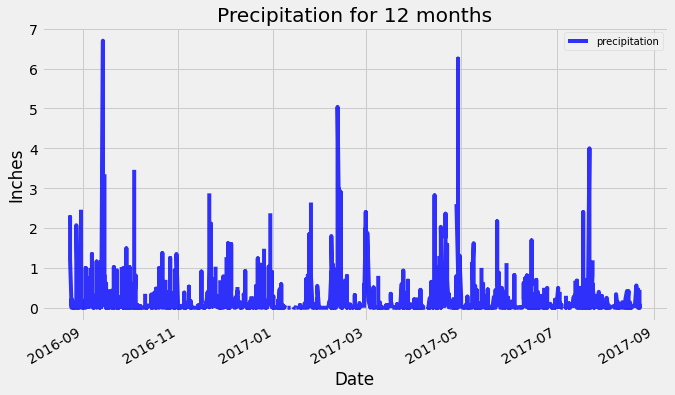

In [45]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date_string).all()
#print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
query_df['date'] = pd.to_datetime(query_df['date'], format='%Y-%m-%d')

# Set index to date
query_df.set_index('date', inplace=True)

# Sort the dataframe by date
query_df = query_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
query_df.plot(title="Precipitation for 12 months", color='blue', alpha=0.8, figsize=(10,6))
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(loc='upper right', prop={'size': 10})
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?
Stations = session.query(Measurement.station).distinct().count()
Stations

9

In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Active_Stations=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
Active_Stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [60]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = Active_Stations[0][0]

temperature_records = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_records
                                    

[(54.0, 85.0, 71.66378066378067)]

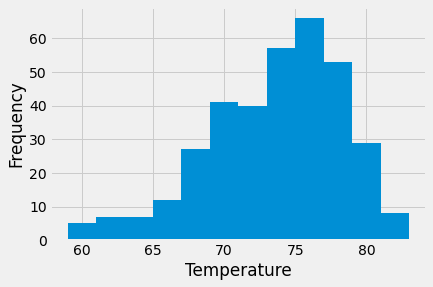

In [74]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_Stations=session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
Temp_Stations
#print(Temp_Stations)

most_active_station = Temp_Stations[0]
#print(most_active_station)

query_12_months =session.query(Measurement.tobs)\
    .filter(Measurement.date >= start_date_string)\
    .filter(Measurement.station == most_active_station)\
    .all()

x_axis = np.array(query_12_months)
#print(x_axis)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.hist(x_axis,bins=12)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
